In [22]:
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import qr
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit, RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, SLSQP, ADAM, GradientDescent
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.7.2


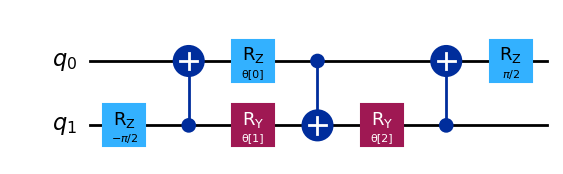

In [23]:
# We now define a two qubit unitary as defined in [3]

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

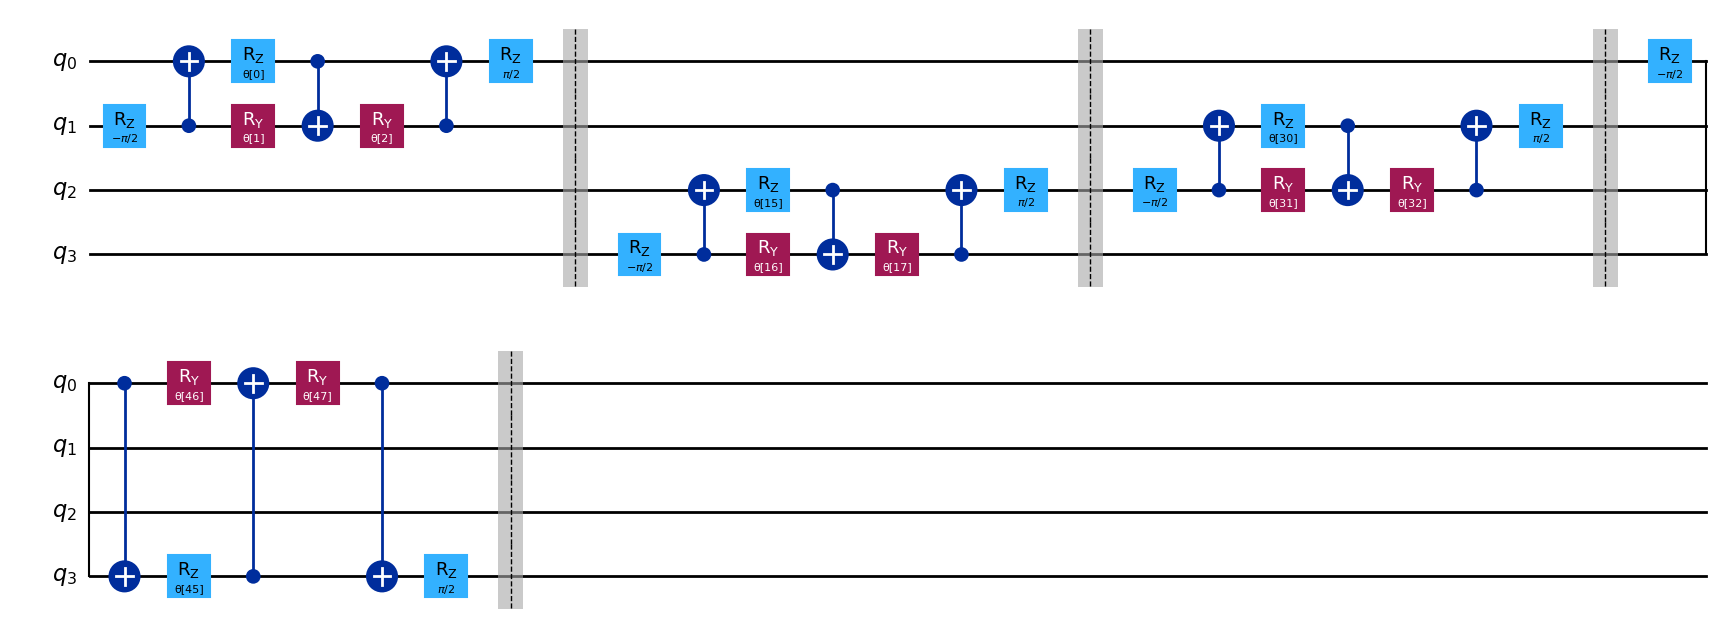

In [24]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

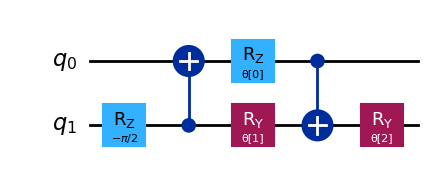

In [25]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

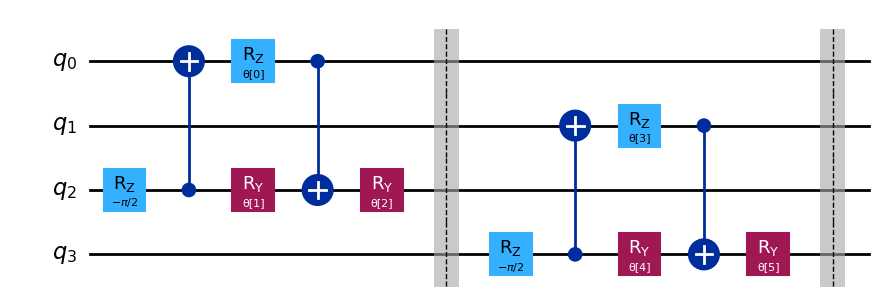

In [26]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [27]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [28]:
a = 3
b = 4
c = 5
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [29]:
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


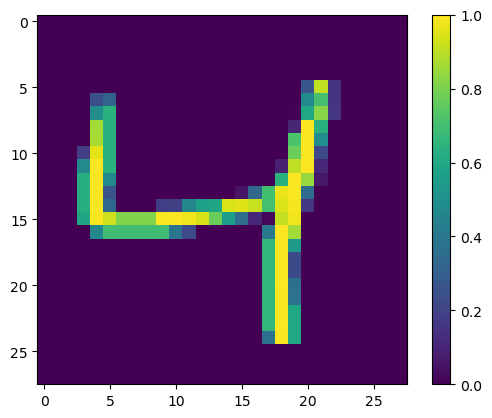

In [30]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [31]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

4


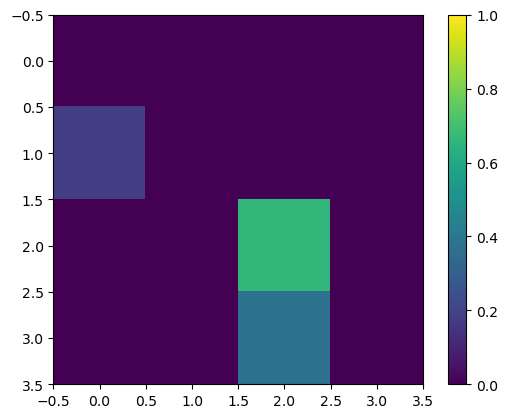

In [32]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [33]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
   
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass


    num_uniq_a = sum(1 for value in mapping.values() if len(value) == 1 and a in value)
    num_uniq_b = sum(1 for value in mapping.values() if len(value) == 1 and b in value)
    num_uniq_c = sum(1 for value in mapping.values() if len(value) == 1 and c in value)
    num_uniq_all = sum(1 for value in mapping.values() if len(value) >= 2)


    print("Number of unique images:", len(mapping.values()))
    print("Number of unique ", a, "'s: ", num_uniq_a)
    print("Number of unique ", b, "'s: ", num_uniq_b)
    print("Number of unique ", c, "'s: ", num_uniq_c)
    print("Number of unique contradicting labels: ", num_uniq_all)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
   
    return np.asarray(new_x), np.asarray(new_y)

In [34]:
import collections
resized_train_images, train_labels = remove_contradicting(x_train_small, y_train)
resized_test_images, test_labels = remove_contradicting(x_test_small, y_test)

Number of unique images: 10254
Number of unique  3 's:  4798
Number of unique  4 's:  5293
Number of unique  5 's:  0
Number of unique contradicting labels:  163

Initial number of images:  11973
Remaining non-contradicting unique images:  10091
Number of unique images: 1833
Number of unique  3 's:  869
Number of unique  4 's:  952
Number of unique  5 's:  0
Number of unique contradicting labels:  12

Initial number of images:  1992
Remaining non-contradicting unique images:  1821


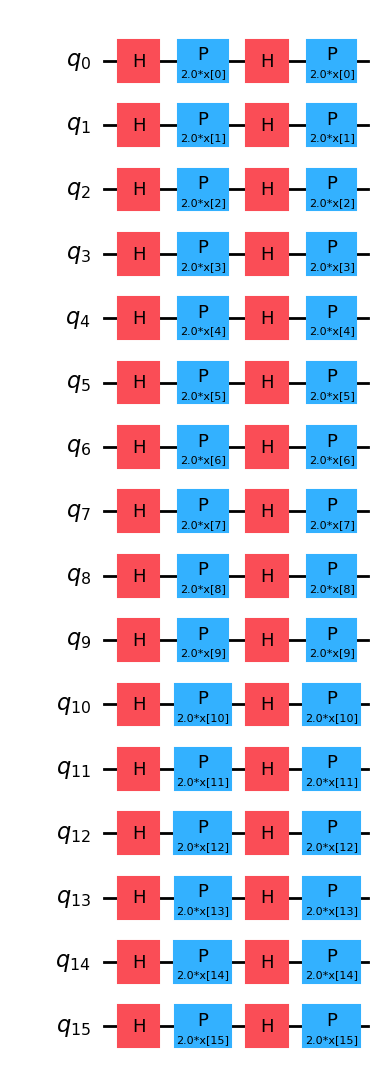

In [35]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

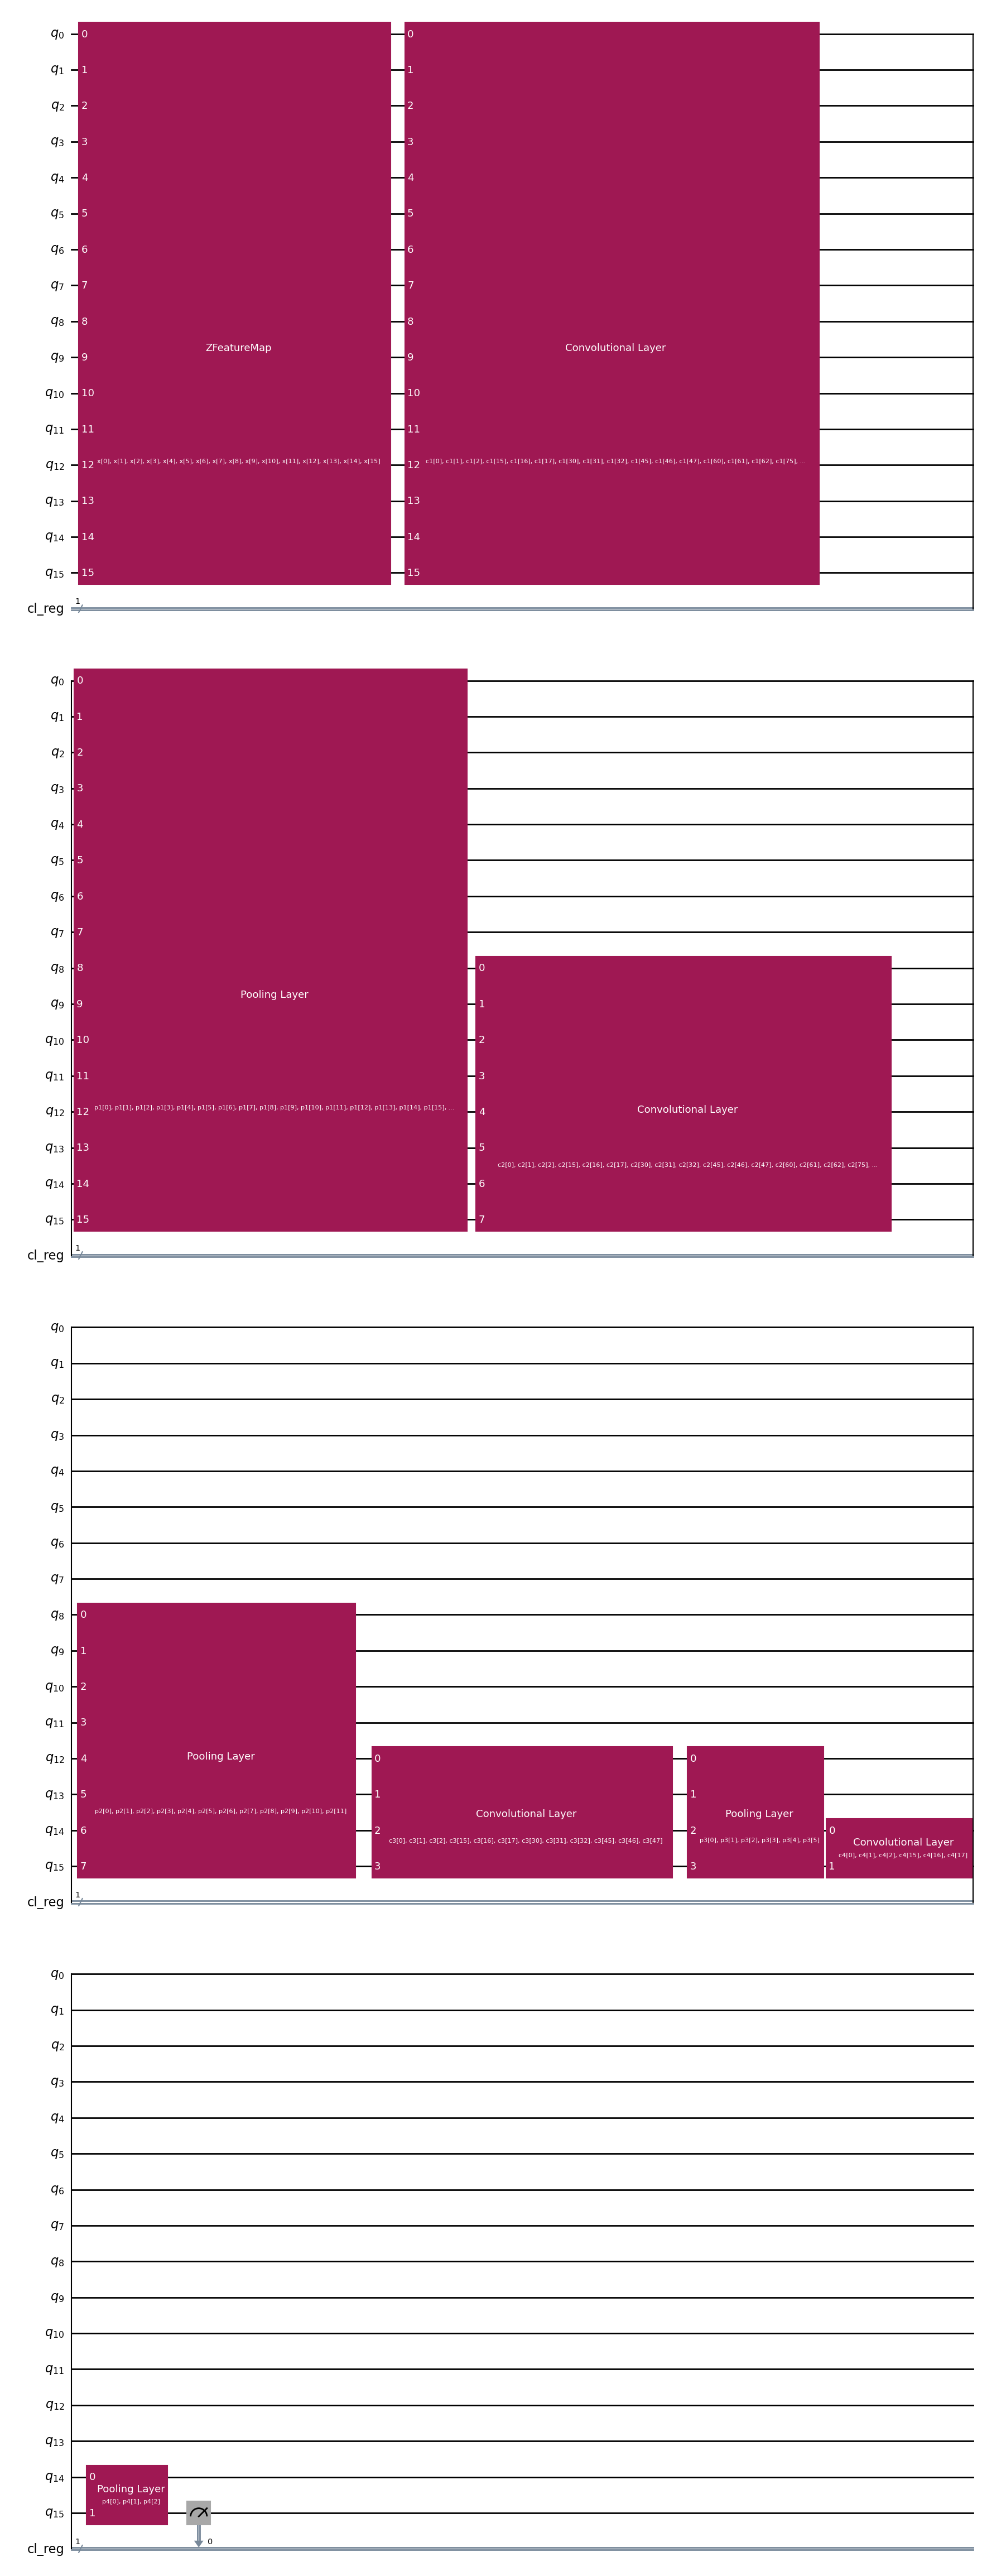

In [ ]:
from qiskit import ClassicalRegister, QuantumRegister
q_reg = QuantumRegister(16, "q_reg")
cl_reg = ClassicalRegister(1, "cl_reg")
feature_map = ZFeatureMap(16)
ansatz = QuantumCircuit(q_reg, cl_reg, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(16, "с1"), list(range(16)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(8, "c2"), list(range(8, 16)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)

# Fourth Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)

# Fourth Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)
ansatz.measure(-1,0)

# Combining the feature map and ansatz
circuit = QNNCircuit(16)
circuit.feature_map = feature_map
circuit.ansatz = ansatz

display(circuit.draw("mpl"))

In [37]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    
  
    print("weights", weights)
    print("objective function value", objective_func_vals)
    
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# parity = lambda x: int("{:b}".format(x), 2) & 1 

# def interpret_last_2_qubit(x):
#     """Interprets the measurement outcome based on the last qubit.

#     Args:
#         x: The measurement outcome as an integer (0 to 2^num_qubits - 1).

#     Returns:
#         int: 1 if the last qubit is 1, 0 if the last qubit is 0.
#     """

#     lambda x: "{:b}".format(x) & 1
#     # output_shape = 4 # Output shape should be 4 because you only have 4 classes
#     # last_bit = x & 1  # Extract the last bit using bitwise AND
#     # second_last_bit = x & 3
#     # return last_bit + second_last_bit  # Returns 1 if last_bit=1, and 0 if last_bit=0

# output_shape = 2

# parity = lambda x: "{:b}".format(x).count("1") % 2
# parity = lambda x: int(bin(x)[2:].zfill(16)[-1])

# def interpret_last_qubit(x):
#     """Interprets the measurement outcome based on the last qubit.

#     Args:
#         x: The measurement outcome as an integer (0 to 2^num_qubits - 1).

#     Returns:
#         int: 1 if the last qubit is 1, 0 if the last qubit is 0.
#     """
#     lambda x: "{:b}".format(x).count("1") & 1  # Extract the last bit using bitwise AND

# output_shape = 2 # Output shape should be 2 because you only have 2 classes

interpret_last_qubit = lambda x: (x >> 15) & 1
output_shape=2

classifier = SamplerQNN(
    circuit = circuit,
    output_shape = output_shape,
    interpret = lambda x: x,
    )

sampler_classifier = NeuralNetworkClassifier(
    neural_network=classifier, optimizer=COBYLA(maxiter=100), callback=callback_graph, warm_start = True, initial_point = [2.32576927,1.05283629,1.28238398,0.55615791,0.91695471,1.47728224
,0.87391805,1.66590026,0.26892484,1.65556034,1.94319478,0.9696652
,2.14812787,2.75679078,1.80136022,1.72192616,1.82268105,0.89897839
,1.27709295,1.37785764,0.16618316,1.20757645,0.30899108,1.91003837
,0.04754983,0.77954128,0.2912439,0.79561583,1.58726279,0.40021878
,2.08446204,2.81386821,1.28942281,0.08284106,0.68745726,2.96460156
,1.23288895,1.1610741,0.7117196,0.60961879,0.48207615,1.2023387
,1.1432638,0.6747598,1.69380388,0.67938488,1.22667116,0.68560872
,1.0374895,0.16114988,0.06361555,1.32161959,0.73150116,0.6255217
,0.42598772,1.06760717,1.60196271,0.06571854,0.28981781,0.29012708
,0.77339201,1.61315483,1.02112815,1.46323599,0.26522908,0.90230351
,0.31714701,0.76547243,0.51402044,0.18457169,0.58706622,1.29653215
,0.15092228,0.55052264,0.98528632,1.3493929,0.64759185,0.61715475
,1.72692948,0.46246145,0.75812604,0.83821453,1.70848636,0.60555253
,0.74244643,1.77684571,0.84863153,1.88953124,1.40789678,0.86449623
,0.80455878,0.63291652,1.41644241,1.36806755,0.79049639,0.89841573
,1.37965769,0.17250031,0.83538418,0.84418883,0.44672753,0.1520348
,0.22513867,0.5306555,0.03947556,0.90427227,0.79003374,0.92496445
,0.96624539,0.30293407,0.33681053,0.3114084,0.71887347,0.27909146
,0.32187033,0.71748371,0.82458466,0.76043266,0.8266806,0.36034941
,0.55551219,0.6258319,0.72477166,0.04263645,0.96639078,0.4730563
,0.96502827,0.30482707,0.21525251,0.83857919,0.08201816,0.60212102
,0.96090423,0.81878007,0.62552282])

In [39]:
x_reshaped = []
x1_reshaped = []

for g in resized_train_images:
    x_reshaped.append(g.reshape(1,16))

for g in resized_test_images:
    x1_reshaped.append(g.reshape(1,16))

final_x = []
final_x1 = []

for entry in x_reshaped:
    final_x.append(entry[0])

for entry in x1_reshaped:
    final_x1.append(entry[0])

# Easier to work with names
x = final_x
y = train_labels
x1 = final_x1
y1 = test_labels

# Setting labels to 0, 1, or 2 to properly process in samplerqnn.
y_temp = []
y1_temp = []

for entry in y:
    if entry == a:
        y_temp.append(0)
    elif entry == b:
        y_temp.append(1)
    else: y_temp.append(2)
y=y_temp

for entry in y1:
    if entry == a:
        y1_temp.append(0)
    elif entry == b:
        y1_temp.append(1)
    else: y1_temp.append(2)
y1=y_temp

x = x[0:1000]
y = y[0:1000]
x1 = x1[0:40]
y1 = y1[0:40]

In [51]:
counta = 0
countb = 0
countc = 0
for i in range(len(y)):
    if y[i] == 0:
        counta+=1
    elif y[i] == 1:
        countb+=1
    else: countc+=1
print(counta, countb)

def balance_lists(x, y, max_count=452):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1

    return x_balanced, y_balanced

x, y = balance_lists(x, y)

counta = 0
countb = 0
countc = 0
for i in range(len(y)):
    if y[i] == 0:
        counta+=1
    elif y[i] == 1:
        countb+=1
    else: countc+=1
print(counta, countb)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

print(x)
print(y)

452 452
452 452
[[0.         0.         0.         ... 0.         0.3764706  0.        ]
 [0.         0.         0.         ... 0.6745098  0.         0.        ]
 [0.         0.         0.         ... 0.6039216  0.19215687 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.9882353  0.         0.        ]
 [0.         0.         0.         ... 0.         0.2        0.        ]]
[1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 0
 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0
 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0
 1 0 1 1 1 1 0 

In [52]:
def fun(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

# Calling this function
x,y = fun(x,y)
print(x)
print(y)

[[0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.99607843 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.99215686 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.9843137  0.         0.        ]
 [0.         0.         0.         ... 0.99215686 0.         0.        ]
 [0.         0.         0.         ... 0.         0.99607843 0.        ]]
[1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1
 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1
 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1
 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0
 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1
 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1
 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 

In [ ]:
# 65 = [1.32576927 1.05283629 1.28238398 0.55615791 0.91695471 0.47728224
#  0.87391805 0.66590026 0.26892484 1.65556034 0.94319478 0.9696652
#  1.14812787 1.75679078 0.80136022 0.72192616 0.82268105 0.89897839
#  1.27709295 1.37785764 0.16618316 1.20757645 0.30899108 1.91003837
#  0.04754983 0.77954128 0.2912439  0.79561583 0.58726279 0.40021878
#  1.08446204 1.81386821 0.28942281 0.08284106 0.68745726 1.96460156
#  1.23288895 1.1610741  0.7117196  0.60961879 0.48207615 1.2023387
#  1.1432638  0.6747598  1.69380388 0.67938488 1.22667116 0.68560872
#  1.0374895  0.16114988 0.06361555 1.32161959 0.73150116 0.6255217
#  0.42598772 1.06760717 1.60196271 0.06571854 0.28981781 0.29012708
#  0.77339201 1.61315483 1.02112815 1.46323599 0.26522908 1.90230351
#  0.31714701 0.76547243 0.51402044 0.18457169 0.58706622 0.29653215
#  0.15092228 0.55052264 0.98528632 0.3493929  0.64759185 0.61715475
#  0.72692948 0.46246145 0.75812604 0.83821453 0.70848636 0.60555253
#  0.74244643 0.77684571 0.84863153 0.88953124 0.40789678 0.86449623
#  0.80455878 0.63291652 0.41644241 0.36806755 0.79049639 0.89841573
#  0.37965769 0.17250031 0.83538418 0.84418883 0.44672753 0.1520348
#  0.22513867 0.5306555  0.03947556 0.90427227 0.79003374 0.92496445
#  0.96624539 0.30293407 0.33681053 0.3114084  0.71887347 0.27909146
#  0.32187033 0.71748371 0.82458466 0.76043266 0.8266806  0.36034941
#  0.55551219 0.6258319  0.72477166 0.04263645 0.96639078 0.4730563
#  0.96502827 0.30482707 0.21525251 0.83857919 0.08201816 0.60212102
#  0.96090423 0.81878007 0.62552282]

# ~ 140[2.32576927,1.05283629,1.28238398,0.55615791,0.91695471,1.47728224
# ,0.87391805,1.66590026,0.26892484,1.65556034,1.94319478,0.9696652
# ,2.14812787,2.75679078,1.80136022,1.72192616,1.82268105,0.89897839
# ,1.27709295,1.37785764,0.16618316,1.20757645,0.30899108,1.91003837
# ,0.04754983,0.77954128,0.2912439,0.79561583,1.58726279,0.40021878
# ,2.08446204,2.81386821,1.28942281,0.08284106,0.68745726,2.96460156
# ,1.23288895,1.1610741,0.7117196,0.60961879,0.48207615,1.2023387
# ,1.1432638,0.6747598,1.69380388,0.67938488,1.22667116,0.68560872
# ,1.0374895,0.16114988,0.06361555,1.32161959,0.73150116,0.6255217
# ,0.42598772,1.06760717,1.60196271,0.06571854,0.28981781,0.29012708
# ,0.77339201,1.61315483,1.02112815,1.46323599,0.26522908,0.90230351
# ,0.31714701,0.76547243,0.51402044,0.18457169,0.58706622,1.29653215
# ,0.15092228,0.55052264,0.98528632,1.3493929,0.64759185,0.61715475
# ,1.72692948,0.46246145,0.75812604,0.83821453,1.70848636,0.60555253
# ,0.74244643,1.77684571,0.84863153,1.88953124,1.40789678,0.86449623
# ,0.80455878,0.63291652,1.41644241,1.36806755,0.79049639,0.89841573
# ,1.37965769,0.17250031,0.83538418,0.84418883,0.44672753,0.1520348
# ,0.22513867,0.5306555,0.03947556,0.90427227,0.79003374,0.92496445
# ,0.96624539,0.30293407,0.33681053,0.3114084,0.71887347,0.27909146
# ,0.32187033,0.71748371,0.82458466,0.76043266,0.8266806,0.36034941
# ,0.55551219,0.6258319,0.72477166,0.04263645,0.96639078,0.4730563
# ,0.96502827,0.30482707,0.21525251,0.83857919,0.08201816,0.60212102
# ,0.96090423,0.81878007,0.62552282]

cpt_240 = [3.32576927,1.05283629,1.28238398,0.55615791,0.91695471,1.47728224
,0.87391805,1.66590026,0.26892484,1.65556034,1.94319478,0.9696652
,2.14812787,3.75679078,1.80136022,1.72192616,1.82268105,0.89897839
,1.27709295,1.37785764,0.16618316,1.20757645,0.30899108,1.91003837
,0.04754983,0.77954128,1.2912439,0.79561583,2.58726279,0.40021878
,3.08446204,2.81386821,1.28942281,1.08284106,0.68745726,2.96460156
,1.23288895,2.1610741,0.7117196,0.60961879,0.48207615,1.2023387
,2.1432638,0.6747598,1.69380388,1.67938488,2.22667116,0.68560872
,1.0374895,0.16114988,0.06361555,1.32161959,0.73150116,0.6255217
,0.42598772,1.06760717,1.60196271,0.06571854,1.28981781,0.29012708
,1.77339201,1.61315483,1.02112815,1.46323599,1.26522908,1.90230351
,0.31714701,0.76547243,0.51402044,0.18457169,0.58706622,1.29653215
,0.15092228,0.55052264,0.98528632,1.3493929,0.64759185,0.61715475
,1.72692948,0.46246145,0.75812604,0.83821453,1.70848636,0.60555253
,0.74244643,1.77684571,0.84863153,1.88953124,1.40789678,0.86449623
,0.80455878,0.63291652,1.41644241,1.36806755,0.79049639,0.89841573
,1.37965769,0.17250031,1.83538418,0.84418883,0.44672753,0.1520348
,0.22513867,0.5306555,0.03947556,0.90427227,0.79003374,0.92496445
,0.96624539,0.30293407,0.33681053,0.3114084,0.71887347,0.27909146
,0.32187033,0.71748371,0.82458466,0.76043266,0.8266806,0.36034941
,0.55551219,0.6258319,0.72477166,0.04263645,0.96639078,0.4730563
,0.96502827,0.30482707,0.21525251,0.83857919,0.08201816,0.60212102
,0.96090423,0.81878007,0.62552282]

# forw = classifier.forward([x[:10]], [1.14014032,3.70128072,2.61949063,2.08338816,1.45692785,1.96072112
# ,1.2797088,0.00493439,1.04867644,2.79086652,0.58341089,0.59916946
# ,0.63685769,1.9746573,1.25611063,1.59182163,2.0417433,1.13359609
# ,1.42793549,0.09692888,0.12651144,0.04056969,0.70611811,0.65948137
# ,0.9324917,0.98544911,0.72555248,0.83194788,1.43463367,1.44143553
# ,0.19470604,1.70379998,0.02896943,0.75716109,0.58295377,0.96612967
# ,0.61526708,0.39397534,1.15774963,0.08865258,0.09207906,0.2154926
# ,0.39954928,0.95863286,0.19408251,0.96090874,0.54728269,0.0744824
# ,0.8705264,0.83452986,0.66139873,0.77178938,0.18357585,0.14606659
# ,0.12066866,0.77767512,0.37984015,0.66737233,0.47435006,0.98076016
# ,0.22935183,0.19302429,0.82018107,0.70806802,0.06684134,0.31855234
# ,0.9604104,0.41152542,0.4181208,0.8474115,0.79058004,0.23792539
# ,0.4412043,0.46104949,0.1561367,0.88823213,0.28959724,0.92757794
# ,0.98471568,0.09198045,0.00684954,0.36126858,0.32877564,0.69918657
# ,0.14210613,0.07397703,0.60633784,0.42928559,0.06245488,0.50818147
# ,0.69846663,0.19124238,0.77982498,0.91313327,0.3667218,0.98514423
# ,0.06948598,0.83398878,0.41209368,0.67069015,0.10362578,0.31298192
# ,0.48710696,0.20090825,0.9144178,0.28471718,0.91485124,0.4595082
# ,0.35356454,0.83124615,0.50298255,0.87420584,0.01638214,0.00970581
# ,0.21992421,0.38567239,0.06093838,0.61536207,0.00781736,0.13885172
# ,0.80595735,0.19489185,0.0312309,0.43332281,0.68996105,0.95227829
# ,0.33405978,0.89631094,0.32495728,0.56485073,0.98347649,0.11321352
# ,0.78757657,0.21821425,0.22537686])
# print(forw)

[[[0.47524033 0.52475967]
  [0.49968109 0.50031891]
  [0.50370666 0.49629334]
  [0.47643897 0.52356103]
  [0.47958769 0.52041231]
  [0.51158089 0.48841911]
  [0.4743827  0.5256173 ]
  [0.47841533 0.52158467]
  [0.49685516 0.50314484]
  [0.50532323 0.49467677]]]


In [ ]:
# sampler_classifier = NeuralNetworkClassifier.load("modelsampler1") #Cpt 100


weights [3.32576927 1.05283629 1.28238398 0.55615791 0.91695471 1.47728224
 0.87391805 1.66590026 0.26892484 1.65556034 1.94319478 1.9696652
 2.14812787 3.75679078 1.80136022 1.72192616 1.82268105 0.89897839
 1.27709295 1.37785764 0.16618316 1.20757645 0.30899108 1.91003837
 0.04754983 0.77954128 1.2912439  0.79561583 2.58726279 0.40021878
 4.08446204 2.81386821 2.28942281 1.08284106 0.68745726 2.96460156
 1.23288895 2.1610741  0.7117196  0.60961879 0.48207615 1.2023387
 2.1432638  0.6747598  2.69380388 1.67938488 2.22667116 0.68560872
 1.0374895  0.16114988 1.06361555 1.32161959 0.73150116 0.6255217
 0.42598772 1.06760717 1.60196271 0.06571854 1.28981781 0.29012708
 1.77339201 1.61315483 1.02112815 1.46323599 2.26522908 1.90230351
 0.31714701 0.76547243 0.51402044 0.18457169 0.58706622 1.29653215
 0.15092228 0.55052264 0.98528632 1.3493929  0.64759185 0.61715475
 1.72692948 0.46246145 0.75812604 0.83821453 1.70848636 0.60555253
 0.74244643 1.77684571 0.84863153 1.88953124 1.40789678 0

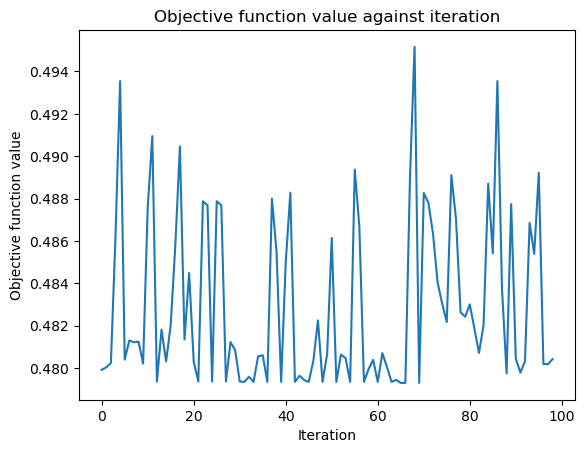

In [ ]:
sampler_classifier.fit(x,y) #check if x is only going to 4

In [ ]:
print(f"Accuracy from the train data: {np.round(100 * sampler_classifier.score(x, y), 2)}%")

Accuracy from the train data: 50.11%


In [ ]:
y_predict = sampler_classifier.predict(x1)
print(f"Accuracy from the test data: {np.round(100 * sampler_classifier.score(x1, y1), 2)}%")

Accuracy from the test data: 50.0%


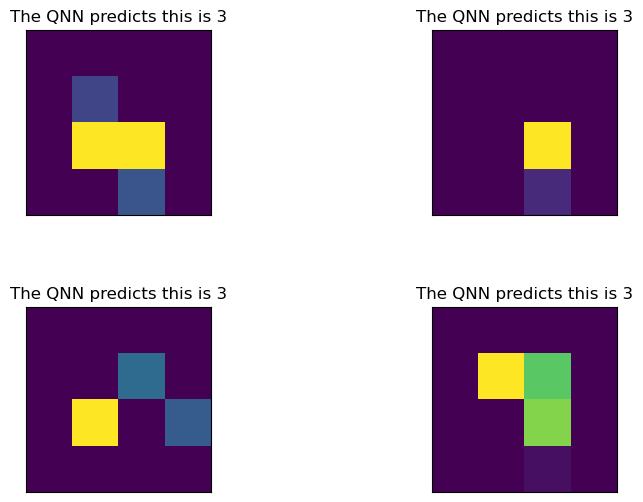

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(x1[i].reshape(4, 4), aspect="equal")
    if y_predict[i] == 0:
        ax[i // 2, i % 2].set_title("The QNN predicts this is 3")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QNN predicts this 4")
    if y_predict[i] == 2:
        ax[i // 2, i % 2].set_title("The QNN predicts this 5")   
    if y_predict[i] == 3:
        ax[i // 2, i % 2].set_title("The QNN predicts this 6") 
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
y_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
y1

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
sampler_classifier.save("modelsampler340")